In [1]:
import os
import re
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore')

# Dengue in Singapore: A Predictive Model for NEA

## Table of Contents

1. [Background](#Background)
2. [Approach](#Approach)
3. [Helper Functions](#Helpers)
4. [Data Compilation](#Data-Compilation)
   1. [Dengue](#Data---Dengue)
   2. [Weather](#Data---Weather)
   3. [Google Trends](#Data---Google-Trends)
   4. [Wolbachia and External Events](#Data---Wolbachia-and-External-Events)
   5. [Compiled Dataset](#Compiled-Dataset)
5. [Forecast Models](#Forecast-Models)
   1. [Linear Regression](#Linear-Regression)
   2. [ARIMA/SARIMAX](#ARIMA/SARIMAX)
   3. [XGBoost](#XGBoost)
6. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Background

Dengue fever, transmitted by Aedes mosquitoes, is a significant health issue in Singapore. The National Environment Agency (NEA) combats dengue through initiatives like the BLOCK strategy, which eliminates mosquito breeding sites, and the Wolbachia project, releasing male mosquitoes that prevent eggs from hatching. A predictive model using weather data, Google search trends, and other external events can enhance NEA's dengue management by forecasting weekly case counts over an 8-week window. Linear regression, SARIMAX, and XGBoost are employed in this project to provide accurate forecasts, helping NEA allocate resources and implement preventive measures effectively.

## Approach

The dengue fever forecast model presented herein is trained on a dataset comprising dengue fever records, historical weather conditions, NEA's combat against dengue, external factors like COVID-related lockdowns and increased construction activity, etc. The dataset is compiled using data from various sources including scraped data from [weather.gov](http://www.weather.gov.sg/climate-historical-daily/), [data.gov](https://data.gov.sg/), [NEA](https://www.nea.gov.sg/), etc. Additional data is gathered through desk research to quantify Wolbachia efforts by determining the proportion of Singaporean estates where male Wolbachia-Aedes mosquitoes are released. The impact of COVID-19 related restrictions and subsequent increased post-lockdown construction activity, both of which have influenced dengue cases, is also considered. Details of the data-gathering process is provided in the accompanying notebook `???`.

This notebook outlines the development of models using techniques such as linear regression, SARIMAX, and XGBoost to understand the factors driving dengue cases and plan effective interventions. Ann evaluation of these models to compare their performance is included to determine the most suitable approach for the task.

## Helpers

In [2]:
def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions for a sequence of time points, using newly predicted target values as
    lagged target values for the prediction of the next time point/
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                                   # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                        # Lag values for labels
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

week_to_month = {
    1: 'Jan', 2: 'Jan', 3: 'Jan', 4: 'Jan',
    5: 'Jan', 6: 'Feb', 7: 'Feb', 8: 'Feb',
    9: 'Feb', 10: 'Mar', 11: 'Mar', 12: 'Mar',
    13: 'Mar', 14: 'Apr', 15: 'Apr', 16: 'Apr',
    17: 'Apr', 18: 'May', 19: 'May', 20: 'May',
    21: 'May', 22: 'May', 23: 'Jun', 24: 'Jun',
    25: 'Jun', 26: 'Jun', 27: 'Jul', 28: 'Jul',
    29: 'Jul', 30: 'Jul', 31: 'Aug', 32: 'Aug',
    33: 'Aug', 34: 'Aug', 35: 'Aug', 36: 'Sep',
    37: 'Sep', 38: 'Sep', 39: 'Sep', 40: 'Oct',
    41: 'Oct', 42: 'Oct', 43: 'Oct', 44: 'Oct',
    45: 'Nov', 46: 'Nov', 47: 'Nov', 48: 'Nov',
    49: 'Dec', 50: 'Dec', 51: 'Dec', 52: 'Dec'
}

## Data Compilation

Loading all data for cleaning and compiling. We consider data from 2012 to present (i.e. July 2024) for this project.

In [3]:
datapath = r'../assets/'

# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
# df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))
df_weather_datagov_RH_raw = pd.read_csv(os.path.join(datapath,'datagov_RH.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))
df_trend_fever_raw = pd.read_csv(os.path.join(datapath,'google_trend_fever.csv'))
df_trend_mosquito_raw = pd.read_csv(os.path.join(datapath,'google_trend_mosquito.csv'))

# Wolbachia
df_wolbachia_raw = pd.read_csv(os.path.join(datapath,'wolbachia_ratio.csv'))

### Data - Dengue

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [4]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

,Week,Dengue_Count
Year,,
2012,52,52
2013,52,52
2014,53,53
2015,53,53
2016,53,53
2017,53,53
2018,53,53
2019,47,47
2020,53,53


### Data - Weather

Next, we clean and compile the __weather__ data. Most of the weather data has been scraped from NEA. Missing data was encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [5]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
70566,16,Chai Chee,2021,10,17,20.8,15.0,17.6,17.6,-1.0,-1.0,-1.0,-1.0,-1.0
73646,14,Tanjong Katong,2013,3,15,1.8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
128447,16,Dhoby Ghaut,2019,3,17,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
177003,16,Khatib,2016,1,17,22.6,12.2,16.8,20.4,26.6,31.8,24.2,3.6,27.0
100580,7,Whampoa,2022,11,8,31.2,29.0,30.4,30.6,-1.0,-1.0,-1.0,-1.0,-1.0


Our dengue dataset above provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. Note that the highest rainfall columns consist of more than 100 missing values.

In [6]:
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Day','date','Month','Station'],inplace=True)              # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Week']).mean()

# Check for missing values.
print(df_weather_NEA.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 654 entries, (2012, 1) to (2024, 26)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      654 non-null    float64
 1   Highest_30mm_Rain   550 non-null    float64
 2   Highest_60mm_Rain   550 non-null    float64
 3   Highest_120mm_Rain  550 non-null    float64
 4   Mean_Temperature    654 non-null    float64
 5   Max_Temperature     654 non-null    float64
 6   Min_Temperature     654 non-null    float64
 7   Min_Wind_Speed      654 non-null    float64
 8   Max_Wind_speed      654 non-null    float64
dtypes: float64(9)
memory usage: 47.7 KB
None


We drop highest 30mm, 60mm and 120mm rainfall columns for simplicity.

In [7]:
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather_NEA = df_weather_NEA.reset_index()

Humidity is well-known to be correlated with dengue fever but not provided by the NEA source. Therefore, we additionally look at relative humidity data from a separate dataset obtained from data.gov.sg.

In [8]:
# Get relative humidity dataframe
df_RH_datagov = df_weather_datagov_RH_raw.copy()
df_RH_datagov.sample(5)

,month,mean_rh
64,2017-05,82.8
28,2014-05,80.2
42,2015-07,74.9
117,2021-10,78.3
22,2013-11,84.6


 As shown, this dataset provides only monthly values. We assume that the relative humidity is constant over each month and fill in the missing values for each week accordingly.

In [9]:
# Fill in values for each week of year
df_RH_datagov['Year'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().year           # Create year column
df_RH_datagov['Week'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().week           # Create week column
df_RH_datagov.drop(columns=['month'],inplace=True)
df_RH_datagov.rename(columns={'mean_rh':'Relative_Humidity'},inplace=True)
df_weeks_temp = df_weather_NEA[['Year','Week']]                                                         # Get weeks of year over range of years considered
df_RH_datagov = df_RH_datagov.merge(df_weeks_temp,on=['Year','Week'],how='outer')
df_RH_datagov.ffill(inplace=True)                                                                       # Assume same humidity over all weeks of month

The relative humidity dataframe is merged into the weather dataframe to give the complete weather features required.

In [10]:
# Merge relative humidity data into other weather data
df_weather = df_weather_NEA.merge(df_RH_datagov,on=['Year','Week'],how='left')
df_weather.sample(5)

,Year,Week,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity
528,2022,5,5.074922,27.752679,32.057143,25.271429,9.575455,34.479091,80.3
154,2014,51,14.923325,26.791729,30.700752,24.602256,7.134127,33.021429,82.6
197,2015,42,0.516749,29.146429,32.842857,26.716429,7.514286,26.558571,75.4
526,2022,3,2.278505,27.465487,31.860177,24.948673,10.396226,34.664151,77.4
237,2016,29,15.605585,27.178906,30.696970,24.224242,7.655303,34.953030,77.3


### Data - Google Trends

Next, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue", "dengue+symptoms", "fever", and "mosquito".

In [11]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_fever = df_trend_fever_raw.copy()
df_trend_mosquito = df_trend_mosquito_raw.copy()

df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)
df_trend_fever.rename(columns={'fever: (Singapore)':'Trend_Fever'},inplace=True)
df_trend_mosquito.rename(columns={'mosquito: (Singapore)':'Trend_Mosquito'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week
df_trend_fever['Year'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().year
df_trend_fever['Week'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().week
df_trend_mosquito['Year'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().year
df_trend_mosquito['Week'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().week


# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_fever,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_mosquito,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

,Week,Trend_Dengue,Year,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito
0,52,51,2014,58,72,58
8,1,51,2015,74,71,71
9,2,51,2015,66,74,59
10,3,49,2015,60,69,59
11,4,62,2015,62,70,68
...,...,...,...,...,...,...
800,24,63,2024,59,82,88
801,25,63,2024,77,78,95
802,26,58,2024,76,85,81
803,27,57,2024,73,94,88


### Data - Wolbachia and External Events

External, non-weather events may directly influence dengue incidence. In particular, __Project Wolbachia__ to curb dengue spread may have reduced dengue cases. Here, we consider Wolbachia efforts as the numerical feature `Wolbachia` given by the percentage of Singapore districts with Wolbachia release.

In [12]:
df_wolbachia = df_wolbachia_raw.drop(columns=['Wolbachia_Areas'])
df_wolbachia.sample(5)

,Year,Week,Wolbachia_Ratio
409,2019,41,0.036364
360,2018,45,0.036364
286,2017,24,0.036364
180,2015,24,0.000000
242,2016,33,0.000000


Additionally, __Covid-19 restrictions and increased construction activities__ after restrictions are lifted may have caused a rise in cases. The presence of such restrictions/activities are encoded as a categorical feature `External_Events` here.

In [13]:
df_external_events = df_wolbachia[['Year','Week']]
df_external_events['External_Events'] = 0
df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15) & (df_external_events.Week<=30),'External_Events'] = 1       # Period of high COVID restrictions, start of lockdown: 7th April 2020, end of phase 2: 17th July
df_external_events.loc[(df_external_events.Year==2022) & (df_external_events.Week>=10) & (df_external_events.Week<=40),'External_Events'] = 1       # Period of increased construction activity in 2022 between weeks 10 and 40

### Compiled Dataset

We combined all data we have into a single dataframe. Visualizing all missing data below, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are also missing dengue fever counts.

In [14]:
df_raw = df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
df_raw = df_raw.merge(df_wolbachia,on=['Year','Week'],how='left')
df_raw = df_raw.merge(df_external_events,on=['Year','Week'],how='left')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
0,2011,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,72.0,87.0,68.0,NaN,NaN
157,2014,53,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
263,2016,53,0.0,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,84.8,NaN,NaN,NaN,NaN,0.036364,0.0
316,2017,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
369,2018,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
417,2019,48,NaN,13.375069,27.664486,32.569027,25.070796,7.818033,33.086066,83.9,40.0,39.0,76.0,72.0,0.036364,0.0
418,2019,49,NaN,6.549143,27.418868,30.736036,25.310811,11.496610,39.640678,83.9,40.0,40.0,76.0,67.0,0.036364,0.0
419,2019,50,NaN,27.321003,25.009091,27.382692,23.375000,9.198214,32.920536,83.9,39.0,35.0,88.0,70.0,0.036364,0.0
420,2019,51,NaN,5.785920,26.448889,30.261458,24.387500,8.639167,30.013333,83.9,43.0,57.0,95.0,68.0,0.036364,0.0
421,2019,52,NaN,2.205525,27.395050,31.543925,25.035514,10.892683,33.669106,83.9,22.0,28.0,56.0,64.0,0.036364,0.0


Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [15]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]                           # Drop all week 53s
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes
df_raw = df_raw.reset_index(drop=True)

## Exploratory Data Analysis (EDA)

The compiled dataset used consists of weather conditions, google search trends, as well as indicators for Wolbachia and any external events.

In [16]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
472,2021,5,146.0,0.042075,27.233613,31.453175,24.795161,12.674107,38.059322,73.8,77.0,0.0,60.0,65.0,0.090909,0.0
281,2017,22,66.0,9.986705,28.922449,32.183673,26.379592,8.646154,31.558120,80.2,93.0,81.0,89.0,71.0,0.036364,0.0
124,2014,21,428.0,6.485915,28.114286,31.972143,24.970714,6.327857,29.390000,80.2,57.0,50.0,87.0,42.0,0.000000,0.0
92,2013,41,438.0,9.277619,28.060145,31.656429,24.715714,6.995000,34.125714,79.9,19.0,22.0,49.0,37.0,0.000000,0.0
114,2014,11,225.0,4.446244,27.929286,32.302857,25.046429,10.843571,36.377857,76.0,33.0,37.0,66.0,67.0,0.000000,0.0


As shown below, there are no missing values in the dataset.

In [17]:
# Show dataset datatypes and check for missing values
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   652 non-null    int64  
 1   Week                   652 non-null    int64  
 2   Dengue_Count           652 non-null    float64
 3   Daily_Rainfall         652 non-null    float64
 4   Mean_Temperature       652 non-null    float64
 5   Max_Temperature        652 non-null    float64
 6   Min_Temperature        652 non-null    float64
 7   Min_Wind_Speed         652 non-null    float64
 8   Max_Wind_speed         652 non-null    float64
 9   Relative_Humidity      652 non-null    float64
 10  Trend_Dengue           652 non-null    float64
 11  Trend_Dengue_Symptoms  652 non-null    float64
 12  Trend_Fever            652 non-null    float64
 13  Trend_Mosquito         652 non-null    float64
 14  Wolbachia_Ratio        652 non-null    float64
 15  Extern

First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted.

(1.0, 52.0)

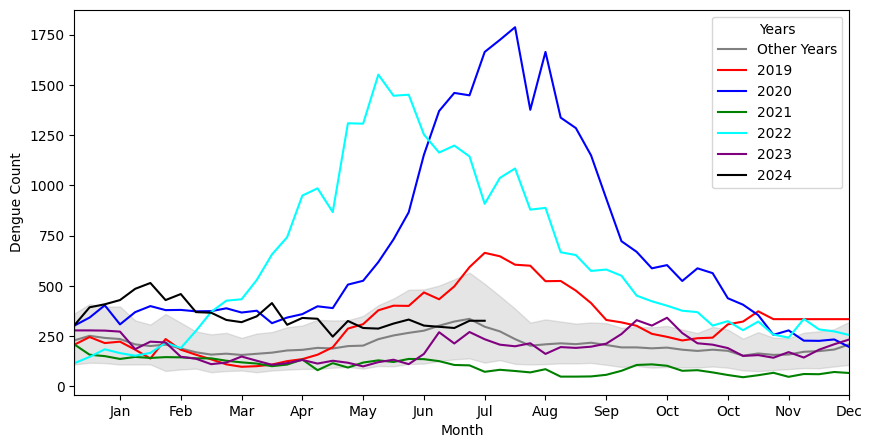

In [18]:
# Create the line plot
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023,2024]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else 'Other Years')
palette = {'Other Years': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple','2024':'black'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)

# Customize x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))      # Format for month names
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: week_to_month.get(int(x), '')))
plt.gca().xaxis.set_major_locator(MultipleLocator(4))  # Show a tick every 4 weeks
ax.set_xlabel('Month')
ax.set_ylabel('Dengue Count')
ax.set_xlim([1,52])
# ax.title('Weekly Values with Monthly X-Axis')


Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature and relative humidity. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

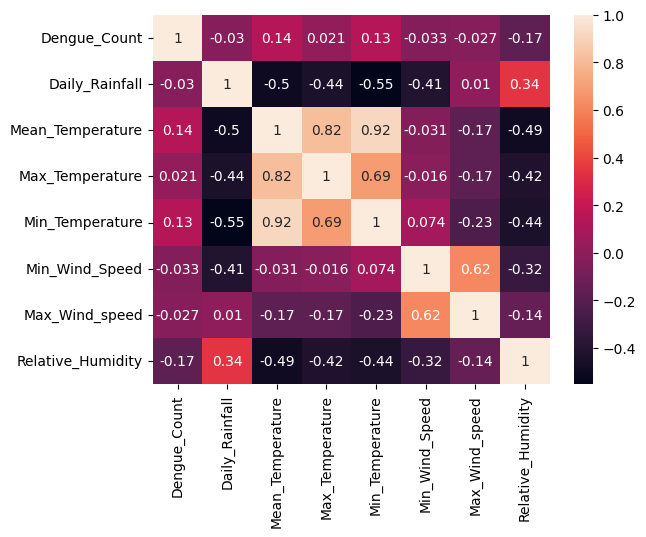

In [19]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed','Relative_Humidity']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

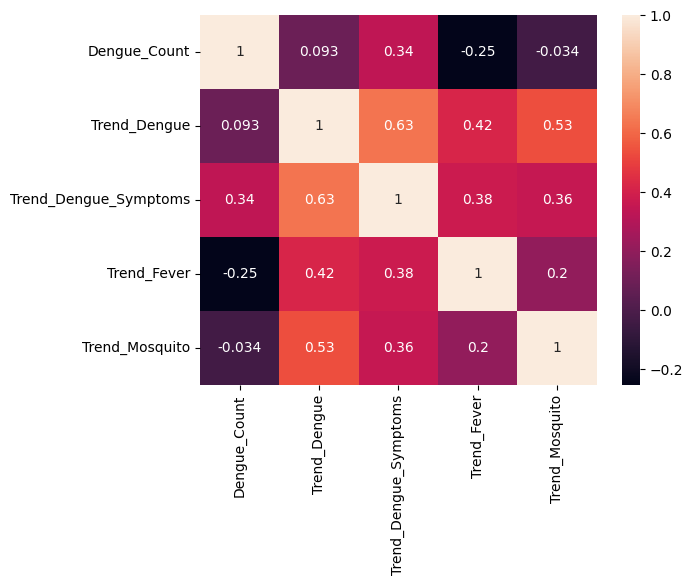

In [20]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever','Trend_Mosquito']].corr(),annot=True)

Finally, we look at the effect of external events with similar plot, showing a strong correlation with external events.

<Axes: >

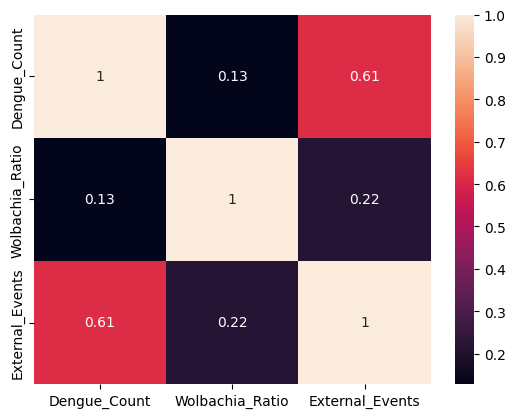

In [21]:
sns.heatmap(df_plot[['Dengue_Count','Wolbachia_Ratio', 'External_Events']].corr(),annot=True)

## Forecast Models

Here, we explore three forecasting models blah blah

### Linear Regression

### ARIMA/SARIMAX

### XGBoost

Next, we consider XGBoost for this forecasting task. Further processing is required to create lagged values of the features and/or targets as additional features as input for the model. We consider using 5 weeks' worth of past data to predict the dengue counts over the next 8 weeks.

First, we consider using only lagged values of the features, not the target values. As shown below, lagged values are added to each row.

In [22]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito', 'Wolbachia_Ratio', 'External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,...,Wolbachia_Ratio_Lag_1,Wolbachia_Ratio_Lag_2,Wolbachia_Ratio_Lag_3,Wolbachia_Ratio_Lag_4,Wolbachia_Ratio_Lag_5,External_Events_Lag_1,External_Events_Lag_2,External_Events_Lag_3,External_Events_Lag_4,External_Events_Lag_5
0,2012,1,74.0,10.266250,26.866026,30.521875,24.589375,10.653125,36.228750,87.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,2,66.0,3.740000,26.434783,29.797143,23.925714,8.486429,33.596429,87.3,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2012,3,61.0,13.200000,27.238235,31.835000,24.474286,6.683571,29.836429,87.3,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,2012,4,52.0,1.522381,26.784672,30.781429,24.417857,9.255714,33.138571,87.3,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4,2012,5,85.0,7.472143,26.544286,30.213571,24.176429,9.028571,33.248571,85.6,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


Next, we split the dataset using `TimeSeriesSplit`, so that we can train our model on one sequence of datapoints, and predict on the following sequence (8 weeks) of datapoints. We perform this splitting below and illustrate the training and prediction process for a few successive time periods.

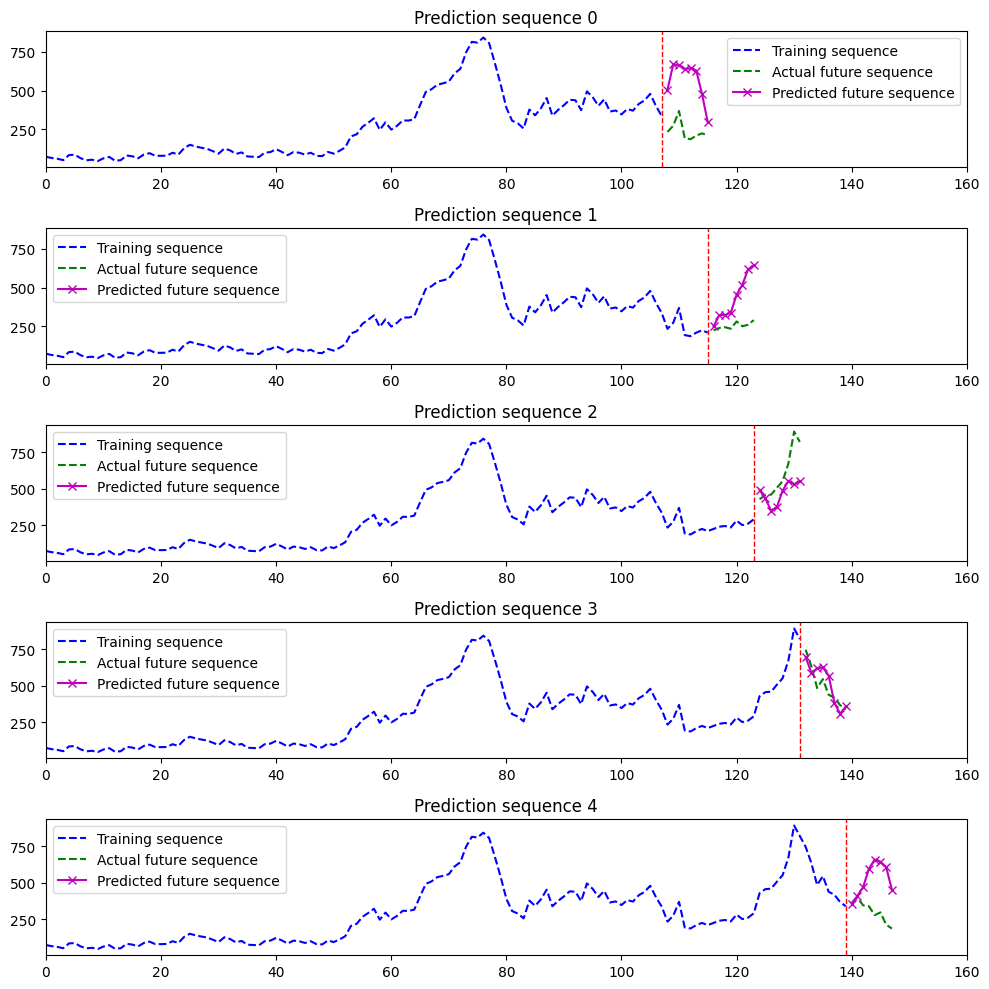

In [35]:
# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
forecast_window = 8
tscv = TimeSeriesSplit(n_splits=68, test_size=forecast_window)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

fig,axs = plt.subplots(5,1,figsize=(10,10))
axs = axs.flatten()

# Collect predictions
preds = []
for i, (train_ind,test_ind) in enumerate(tscv.split(df_features)):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_label.iloc[train_ind])

    # Get prediction
    y_pred = pd.DataFrame(model.predict(df_features.iloc[test_ind,:]))
    y_pred.index = pd.RangeIndex(start=test_ind[0], stop=test_ind[-1]+1)

    axs[i].plot(df_label.iloc[train_ind],'b--',label='Training sequence')
    axs[i].plot(df_label.iloc[test_ind],'g--',label='Actual future sequence')
    axs[i].plot(y_pred,'mx-',label='Predicted future sequence')
    axs[i].set_xlim([0,160])
    axs[i].axvline(x=train_ind[-1], color='r', linestyle='--', linewidth=1)
    axs[i].legend()
    axs[i].set_title(f'Prediction sequence {i}')

    if i == 4:
        break
fig.tight_layout()

We come

In [ ]:
# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
tscv = TimeSeriesSplit(n_splits=68, test_size=8)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for (train_ind,test_ind) in tscv.split(df_features):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_label.iloc[train_ind])

    # Get prediction
    y_pred = model.predict(df_features.iloc[test_ind,:])
    preds.append(y_pred)

df_preds = pd.DataFrame(np.hstack(preds))
start_index = 108
df_preds.index = pd.RangeIndex(start=start_index, stop=start_index + len(df_preds))
rmse = np.sqrt(mean_squared_error(df_label.iloc[108:],df_preds))
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_label,label='Actual Dengue Counts')
ax.plot(df_preds,label='Predicted Dengue Counts')
ax.axvline(x=108, color='r', linestyle='--', linewidth=2, label='Vertical dashed line')
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

For time series data, past data are heavily correlated with current values. This means that past dengue counts will be related to current dengue counts. Here, we add the number of past dengue cases. Search trend features are also included.

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 99.7')

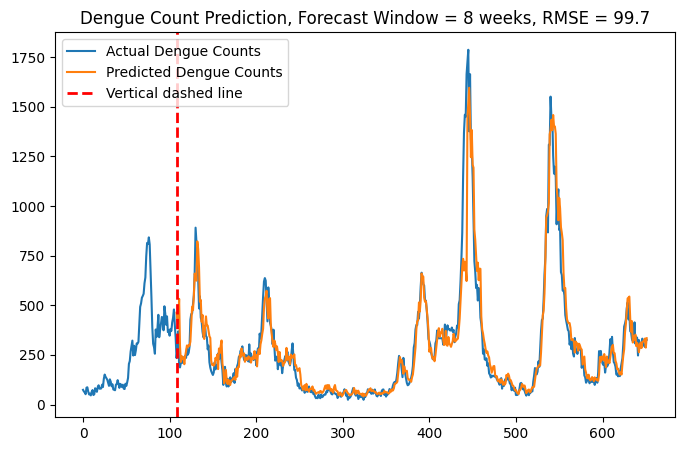

In [83]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
tscv = TimeSeriesSplit(n_splits=68, test_size=8)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for (train_ind,test_ind) in tscv.split(df_features):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_label.iloc[train_ind])

    # Get prediction
    y_pred = model.predict(df_features.iloc[test_ind,:])
    preds.append(y_pred)

df_preds = pd.DataFrame(np.hstack(preds))
start_index = 108
df_preds.index = pd.RangeIndex(start=start_index, stop=start_index + len(df_preds))
rmse = np.sqrt(mean_squared_error(df_label.iloc[108:],df_preds))
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_label,label='Actual Dengue Counts')
ax.plot(df_preds,label='Predicted Dengue Counts')
ax.axvline(x=108, color='r', linestyle='--', linewidth=2, label='Vertical dashed line')
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

In time series forecasting, we make often predictions for multiple future time points rather than just one. In this project, we have selected a forecast window of 8 weeks. If lagged values of the target variables are used, we have to use predicted rather than known values for prediction of later time points in the forecast window. The `get_sequential_predictions` function below perform such a sequential prediction.

In [84]:
from typing import Dict

def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                          # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                                 # Lag values for labels
    
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

We try a quick prediction using a rough xgboost model to see the effect of lagged labels

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 146.8')

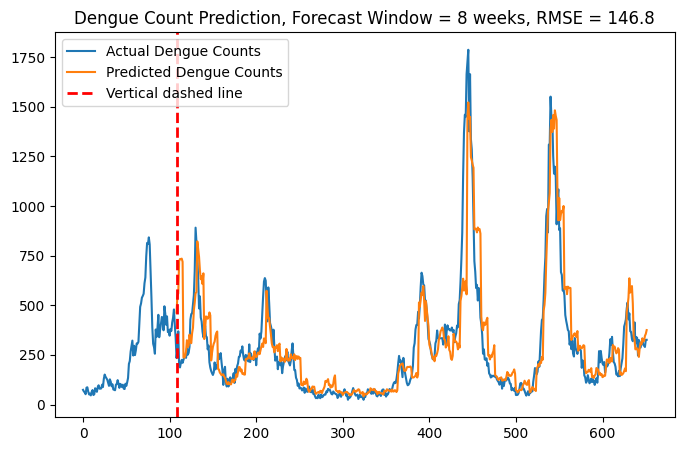

In [85]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
dict_label_lags = {}
for lag in label_lags:
    dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_xgb[dict_label_lags[lag]] = df_xgb['Dengue_Count'].shift(lag)    

# Split into train and test sets
tscv = TimeSeriesSplit(n_splits=68, test_size=8)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for (train_ind,test_ind) in tscv.split(df_features):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_label.iloc[train_ind])

    # Get prediction
    y_pred = get_sequential_predictions(model, df_features.iloc[test_ind,:],
                                        dict_label_lags=dict_label_lags)
    preds.append(y_pred)

df_preds = pd.DataFrame(np.hstack(preds))
start_index = 108
df_preds.index = pd.RangeIndex(start=start_index, stop=start_index + len(df_preds))
rmse = np.sqrt(mean_squared_error(df_label.iloc[108:],df_preds))
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_label,label='Actual Dengue Counts')
ax.plot(df_preds,label='Predicted Dengue Counts')
ax.axvline(x=108, color='r', linestyle='--', linewidth=2, label='Vertical dashed line')
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

As shown, using lagged labels is a double edged sword. When we have perfect knowledge of label (i.e. dengue count) values, the prediction is good (blue). However, when making a prediction three weeks into the future, we need good dengue counts from weeks 1 and 2, which we cannot know before hand. The green curve shows this sequential prediction, using _predicted_ dengue counts from weeks 1 and 2 to predict the value in week 3. As shown by the green curve, the prediction is inferior, as a wrong prediction early in the sequence can lead reduced performance later.

For comparison, the prediction using a model without any lagged labels is shown below.

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 100.0')

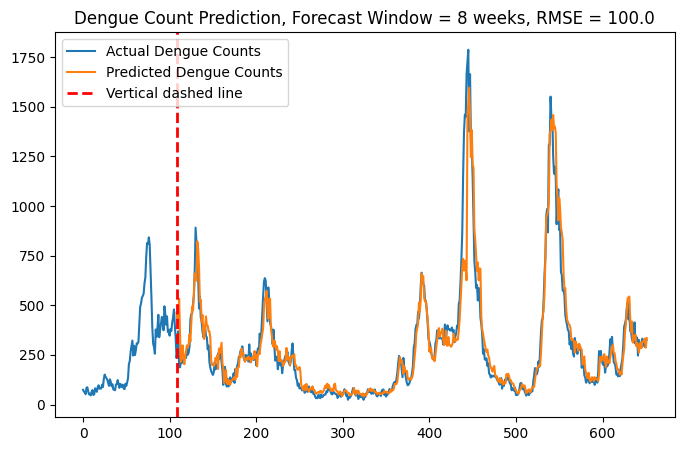

In [86]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.array([3,4])
dict_label_lags = {}
for lag in label_lags:
    dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_xgb[dict_label_lags[lag]] = df_xgb['Dengue_Count'].shift(lag)    

# Split into train and test sets
tscv = TimeSeriesSplit(n_splits=68, test_size=8)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for (train_ind,test_ind) in tscv.split(df_features):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_label.iloc[train_ind])

    # Get prediction
    y_pred = get_sequential_predictions(model, df_features.iloc[test_ind,:],
                                        dict_label_lags=dict_label_lags)
    preds.append(y_pred)

df_preds = pd.DataFrame(np.hstack(preds))
start_index = 108
df_preds.index = pd.RangeIndex(start=start_index, stop=start_index + len(df_preds))
rmse = np.sqrt(mean_squared_error(df_label.iloc[108:],df_preds))
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_label,label='Actual Dengue Counts')
ax.plot(df_preds,label='Predicted Dengue Counts')
ax.axvline(x=108, color='r', linestyle='--', linewidth=2, label='Vertical dashed line')
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

Weak future feature knowledge

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 182.3')

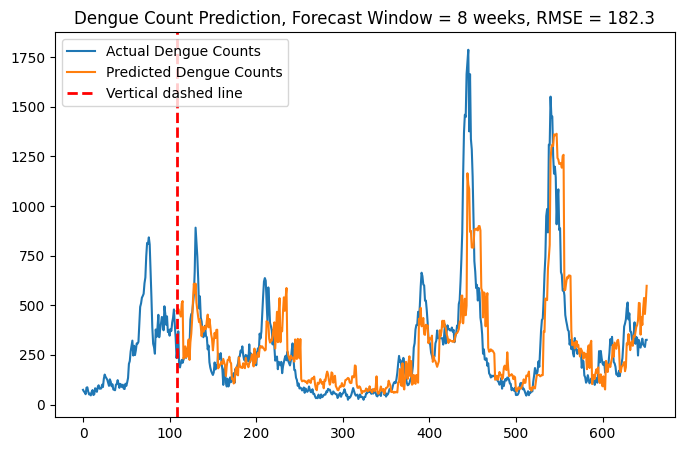

In [114]:
# Define lag characteristics
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
weak_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito']
label_lags = np.array([3,4])

# Define train test split behaviour
tscv = TimeSeriesSplit(n_splits=68, test_size=8)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

preds = [] # Collect predictions
for train_ind, test_ind in tscv.split(df_raw):
    all_ind = np.hstack([train_ind, test_ind])
    df_xgb = df_raw.copy().iloc[all_ind,:]

    # Prep train features with lagged features and target values
    X_train = df_xgb.iloc[train_ind,:]
    for feat in lagged_features:               # Add lagged features
        for lag in lags:
            X_train[f'{feat}_Lag_{lag}'] = X_train[feat].shift(lag)
    dict_label_lags = {}                       # Add lagged targets
    for lag in label_lags:
        dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
        X_train[dict_label_lags[lag]] = X_train['Dengue_Count'].shift(lag)
    X_train = X_train[[col for col in X_train.columns if not (col in ['Year','Dengue_Count'])]]

    # Prep train labels
    y_train = df_xgb.iloc[train_ind,:].loc[:,'Dengue_Count']

    # Create dataframe of historical mean of selected features from train set
    X_train_temp = df_xgb.copy().iloc[train_ind,:]
    mean_feature_values = []
    for feat in weak_features:
        mean_feature_values.append(X_train_temp[['Week',feat]].groupby('Week').mean())
    mean_feature_values = pd.concat(mean_feature_values,axis=1)

    # Replace selected 'known' feature values with historical mean
    df_w_mean = df_xgb.copy().iloc[all_ind,:]
    df_w_mean.drop(columns=weak_features,inplace=True)
    df_w_mean = df_w_mean.merge(mean_feature_values,on='Week',how='left')
    for feat in lagged_features:               # Add lagged features
        for lag in lags:
            df_w_mean[f'{feat}_Lag_{lag}'] = df_w_mean[feat].shift(lag)
    for lag in label_lags:                     # Add lagged features
        df_w_mean[dict_label_lags[lag]] = df_w_mean['Dengue_Count'].shift(lag)
    
    # Get test features and labels
    X_test = df_w_mean[[col for col in df_w_mean.columns if not (col in ['Year','Dengue_Count'])]]
    X_test = X_test.iloc[test_ind,:]
    X_test = X_test[X_train.columns]           # Get test feature columns in the same order as train df

    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Get prediction
    y_pred = get_sequential_predictions(model, X_test, dict_label_lags=dict_label_lags)
    preds.append(y_pred)
    
df_preds = pd.DataFrame(np.hstack(preds))
start_index = 108
df_preds.index = pd.RangeIndex(start=start_index, stop=start_index + len(df_preds))
rmse = np.sqrt(mean_squared_error(df_label.iloc[108:],df_preds))
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_label,label='Actual Dengue Counts')
ax.plot(df_preds,label='Predicted Dengue Counts')
ax.axvline(x=108, color='r', linestyle='--', linewidth=2, label='Vertical dashed line')
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

## Conclusion and Future Work

blah blah lorem ipsum